In [ ]:
try:
    %tensorflow_version 2.x
except:
    pass

In [ ]:
import numpy as np
import matplotlib.pylab as plt

import pathlib
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds
tfds.disable_progress_bar()



In [ ]:
module_selection = ("mobilenet_v2", 224, 1280)
handle_base, pixels, FV_SIZE = module_selection
MODULE_HANDLE ="https://tfhub.dev/google/tf2-preview/{}/feature_vector/4".format(handle_base)
IMAGE_SIZE = (pixels, pixels)
print("Using {} with input size {} and output dimension {}".format(MODULE_HANDLE, IMAGE_SIZE, FV_SIZE))

Using https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4 with input size (224, 224) and output dimension 1280


In [ ]:
train_dir = '/content/drive/MyDrive/RiceLeafsData/train'
validation_dir = '/content/drive/MyDrive/RiceLeafsData/validation'

In [ ]:
import os
classes=[]
for file in os.listdir(train_dir):
    classes+=[file]
print(classes)
print(len(classes))

['tungro', 'Hispa', 'Healthy', 'LeafBlast', 'blight', 'BrownSpot']
6


In [ ]:

'''import PIL
from PIL import Image

for file in os.listdir(validation_dir):
  for content in os.listdir(validation_dir+'/'+file):
    f_img = validation_dir+"/"+file+"/"+content
    img = Image.open(f_img)
    img = img.resize((1500,1500))
    img.save(f_img)

print('finish')'''

'import PIL\nfrom PIL import Image\n\nfor file in os.listdir(validation_dir):\n  for content in os.listdir(validation_dir+\'/\'+file):\n    f_img = validation_dir+"/"+file+"/"+content\n    img = Image.open(f_img)\n    img = img.resize((1500,1500))\n    img.save(f_img)\n\nprint(\'finish\')'

In [ ]:
# Create a labels.txt file with the class names
with open('labels.txt', 'w') as f:
    f.write('\n'.join(classes))

In [ ]:
BATCH_SIZE = 32
IMG_WIDTH = 224
IMG_HEIGHT = 224

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
        rescale=1./255,
        vertical_flip=True,
        fill_mode = 'nearest',
        #channel_shift_range=0.5,
        rotation_range=25,
        zoom_range=[0.5, 1],
        
        )

validation_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    shuffle=True,
    batch_size=BATCH_SIZE,
    target_size=(IMG_HEIGHT,IMG_WIDTH),
    class_mode='sparse'
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    shuffle=True,
    batch_size=BATCH_SIZE,
    target_size=(IMG_HEIGHT,IMG_WIDTH),
    class_mode='sparse'
)

Found 312 images belonging to 6 classes.
Found 168 images belonging to 6 classes.


In [ ]:
do_fine_tuning = True

In [ ]:
feature_extractor = hub.KerasLayer(MODULE_HANDLE,
                                   input_shape=IMAGE_SIZE + (3,), 
                                   output_shape=[FV_SIZE],
                                   trainable=do_fine_tuning)

In [ ]:

model = tf.keras.Sequential([
        feature_extractor,
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(6, activation='softmax')
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 1280)              2257984   
                                                                 
 flatten_1 (Flatten)         (None, 1280)              0         
                                                                 
 dense_2 (Dense)             (None, 128)               163968    
                                                                 
 dense_3 (Dense)             (None, 6)                 774       
                                                                 
Total params: 2,422,726
Trainable params: 2,388,614
Non-trainable params: 34,112
_________________________________________________________________


In [ ]:
NUM_LAYERS = 12 #@param {type:"slider", min:1, max:50, step:1}
      
if do_fine_tuning:
    feature_extractor.trainable = True
    
    for layer in model.layers[-NUM_LAYERS:]:
        layer.trainable = True

else:
    feature_extractor.trainable = False

In [ ]:
if do_fine_tuning:
    model.compile(optimizer=tf.keras.optimizers.SGD(lr=0.0002, momentum=0.9),
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                  metrics=['accuracy'])
else:
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [ ]:
NUM_TRAINING_IMAGES = sum(len(files) for _, _, files in os.walk(train_dir))
NUM_VALIDATION_IMAGES = sum(len(files) for _, _, files in os.walk(validation_dir))

In [ ]:
EPOCHS = 30
STEPS_PER_EPOCH = NUM_TRAINING_IMAGES // BATCH_SIZE
VALIDATION_STEPS = NUM_VALIDATION_IMAGES // BATCH_SIZE 
hist = model.fit(train_generator,
                 epochs=EPOCHS,
                 steps_per_epoch=STEPS_PER_EPOCH,
                 validation_steps = VALIDATION_STEPS,
                 validation_data=validation_generator)

Epoch 1/30
9/9 [==============================] - 108s 11s/step - loss: 2.0053 - accuracy: 0.2250 - val_loss: 2.1776 - val_accuracy: 0.2188
Epoch 2/30
9/9 [==============================] - 93s 10s/step - loss: 1.8286 - accuracy: 0.3036 - val_loss: 2.0383 - val_accuracy: 0.2188
Epoch 3/30
9/9 [==============================] - 91s 10s/step - loss: 1.5873 - accuracy: 0.4429 - val_loss: 1.9288 - val_accuracy: 0.2500
Epoch 4/30
9/9 [==============================] - 92s 10s/step - loss: 1.4740 - accuracy: 0.5071 - val_loss: 1.8253 - val_accuracy: 0.2750
Epoch 5/30
9/9 [==============================] - 92s 10s/step - loss: 1.2862 - accuracy: 0.6286 - val_loss: 1.7780 - val_accuracy: 0.2937
Epoch 6/30
9/9 [==============================] - 99s 11s/step - loss: 1.1578 - accuracy: 0.6964 - val_loss: 1.6977 - val_accuracy: 0.3125
Epoch 7/30
9/9 [==============================] - 95s 10s/step - loss: 1.0581 - accuracy: 0.7188 - val_loss: 1.6143 - val_accuracy: 0.3812
Epoch 8/30
9/9 [==========

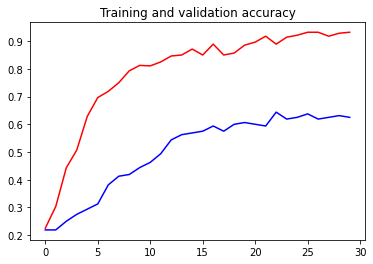

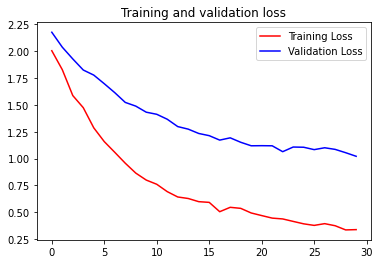

In [ ]:
# Plot the model results
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
loss = hist.history['loss']
val_loss = hist.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')

plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path = fn
  img = image.load_img(path, target_size=(224, 224))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  print(fn)
  print(classes)

Saving IMG_20190419_113933.jpg to IMG_20190419_113933.jpg
IMG_20190419_113933.jpg
[[0.00439008 0.01420216 0.00498856 0.92451143 0.00410095 0.04780684]]


In [ ]:
model.save('my_model_detect.h5') 

**__________________________________________________________________________________________________**